# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.55KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

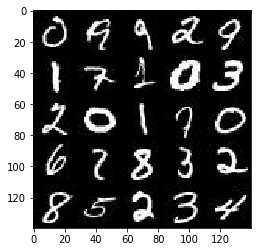

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

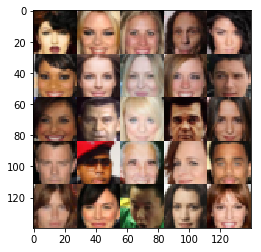

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_inputs')
    real_z = tf.placeholder(tf.float32, (None, z_dim), name = 'real_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return real_inputs, real_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse = reuse):
        layer1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(layer1, 64, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.layers.conv2d(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        layer4 = tf.layers.conv2d(layer3, 256, 5, strides=2, padding='same')
        layer4 = tf.layers.batch_normalization(layer4, training=True)
        layer4 = tf.maximum(alpha * layer4, layer4)

        # Flatten it
        flat = tf.reshape(layer4, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, training = True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not training):
        x = tf.layers.dense(z, 4*4*512)
        
        layer1 = tf.reshape(x, (-1, 4, 4, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=training)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 4, strides=1, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=training)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=training)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        layer4 = tf.layers.conv2d_transpose(layer3, 32, 5, strides=2, padding='same')
        layer4 = tf.layers.batch_normalization(layer4, training=training)
        layer4 = tf.maximum(alpha * layer4, layer4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(layer4, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    discriminator_loss = d_loss_real + d_loss_fake

    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
   
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train = tf.trainable_variables()
    discriminator_var = [x for x in train if x.name.startswith('discriminator')]
    generator_var = [x for x in train if x.name.startswith('generator')]
    
    update = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_updates = [op for op in update if op.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(generator_updates):
        discrimiator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_var)
        generator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_var)
    
    return discrimiator_opt, generator_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    real_inputs, real_z, learning_rate_in = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_inputs, real_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={ real_inputs: batch_images, real_z: batch_z, learning_rate_in: learning_rate })
                _ = sess.run(g_opt, feed_dict={ real_z: batch_z, learning_rate_in: learning_rate })
                
                if steps % print_every == 0:
                    d_loss_train = d_loss.eval({
                        real_z: batch_z,
                        real_inputs: batch_images
                    })
                    g_loss_train = g_loss.eval({
                        real_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(d_loss_train),
                         "Generator Loss: {:.4f}".format(g_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, real_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3656... Generator Loss: 0.0201
Epoch 1/2... Discriminator Loss: 0.4122... Generator Loss: 3.7461
Epoch 1/2... Discriminator Loss: 0.4478... Generator Loss: 2.5254
Epoch 1/2... Discriminator Loss: 0.6432... Generator Loss: 1.8442
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 3.7228
Epoch 1/2... Discriminator Loss: 2.2127... Generator Loss: 6.2796
Epoch 1/2... Discriminator Loss: 2.9054... Generator Loss: 0.0993
Epoch 1/2... Discriminator Loss: 1.7849... Generator Loss: 0.3268
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 1.8762


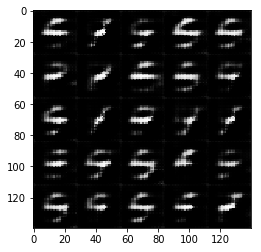

Epoch 1/2... Discriminator Loss: 1.7341... Generator Loss: 1.8066
Epoch 1/2... Discriminator Loss: 0.7590... Generator Loss: 1.4789
Epoch 1/2... Discriminator Loss: 0.8590... Generator Loss: 1.2618
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 1.8058
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 1.1284
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 1.1933
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 2.0439
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.5292
Epoch 1/2... Discriminator Loss: 2.1065... Generator Loss: 5.2561
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 1.2744


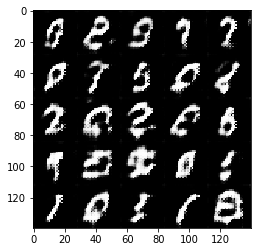

Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 1.2493
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 0.8874... Generator Loss: 1.2635
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.8359
Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 1.7615
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.6801
Epoch 1/2... Discriminator Loss: 1.1681... Generator Loss: 0.7415


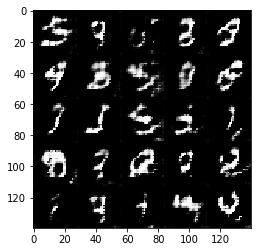

Epoch 1/2... Discriminator Loss: 1.7079... Generator Loss: 0.3735
Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 0.4345
Epoch 1/2... Discriminator Loss: 1.2537... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.8587
Epoch 1/2... Discriminator Loss: 0.9954... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 1.5562... Generator Loss: 0.4255
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 2.3307
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 3.1598
Epoch 1/2... Discriminator Loss: 2.2855... Generator Loss: 0.1862


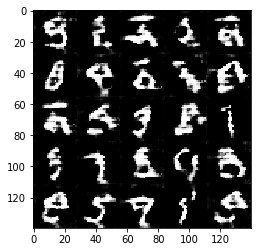

Epoch 1/2... Discriminator Loss: 0.8350... Generator Loss: 1.3499
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 3.1503
Epoch 1/2... Discriminator Loss: 1.0398... Generator Loss: 1.6558
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 1.0013
Epoch 1/2... Discriminator Loss: 1.9987... Generator Loss: 0.3817
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 1.5848
Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 1.2745
Epoch 1/2... Discriminator Loss: 1.4449... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 1.0861


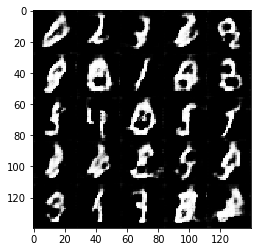

Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 0.8372
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 1.0035
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 1.6625... Generator Loss: 0.4234
Epoch 1/2... Discriminator Loss: 1.6812... Generator Loss: 0.3641
Epoch 1/2... Discriminator Loss: 1.1331... Generator Loss: 1.1784
Epoch 1/2... Discriminator Loss: 1.1955... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 1.4019
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 1.1482


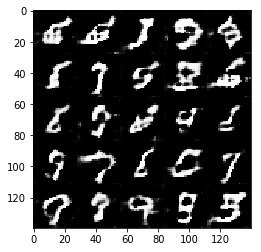

Epoch 1/2... Discriminator Loss: 1.4820... Generator Loss: 0.6076
Epoch 1/2... Discriminator Loss: 2.0197... Generator Loss: 0.2548
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 1.1660
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 0.9914
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 1.8126... Generator Loss: 0.3204
Epoch 1/2... Discriminator Loss: 1.0784... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 1.5304... Generator Loss: 0.4238


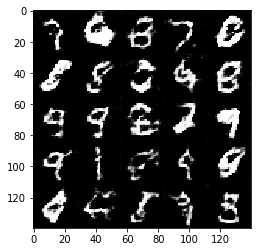

Epoch 1/2... Discriminator Loss: 0.7955... Generator Loss: 1.9814
Epoch 1/2... Discriminator Loss: 1.9689... Generator Loss: 0.2682
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 1.8872... Generator Loss: 0.2727
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.6259
Epoch 1/2... Discriminator Loss: 2.3512... Generator Loss: 0.2055
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 1.9793
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.5481... Generator Loss: 0.4558
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 2.1598


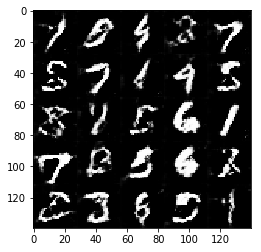

Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 1.3846
Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 1.9214
Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 0.9252... Generator Loss: 1.1436
Epoch 1/2... Discriminator Loss: 1.8290... Generator Loss: 0.3236
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 1.6121... Generator Loss: 0.5561
Epoch 1/2... Discriminator Loss: 0.9594... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 0.9007... Generator Loss: 1.1394
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.8799


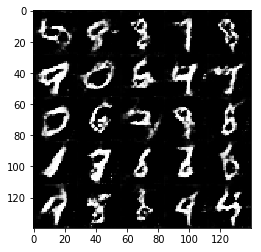

Epoch 1/2... Discriminator Loss: 1.4263... Generator Loss: 0.5234
Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 0.9803
Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 1.7984
Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 1.3233... Generator Loss: 1.0615
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 1.1135
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 0.9816
Epoch 2/2... Discriminator Loss: 1.6700... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 0.8086


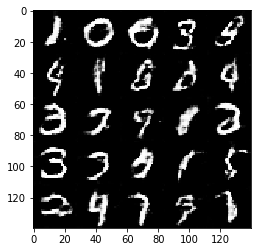

Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 1.4671
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 0.5785
Epoch 2/2... Discriminator Loss: 1.2030... Generator Loss: 0.7318
Epoch 2/2... Discriminator Loss: 0.9944... Generator Loss: 1.2455
Epoch 2/2... Discriminator Loss: 1.6500... Generator Loss: 0.4318
Epoch 2/2... Discriminator Loss: 0.7845... Generator Loss: 1.5908
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 1.4484
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 1.6397... Generator Loss: 0.7624
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 1.0726


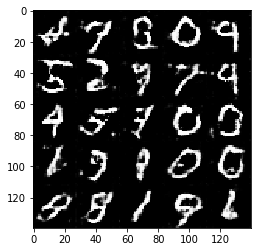

Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 0.8684
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 1.9758
Epoch 2/2... Discriminator Loss: 2.2002... Generator Loss: 0.2546
Epoch 2/2... Discriminator Loss: 1.6319... Generator Loss: 0.4719
Epoch 2/2... Discriminator Loss: 1.8724... Generator Loss: 0.3062
Epoch 2/2... Discriminator Loss: 1.3122... Generator Loss: 0.5397
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 2.6566
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 0.9613
Epoch 2/2... Discriminator Loss: 1.4274... Generator Loss: 0.5880
Epoch 2/2... Discriminator Loss: 1.6293... Generator Loss: 0.4038


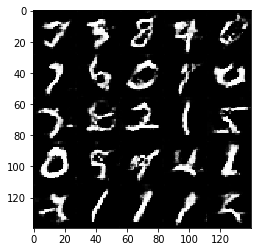

Epoch 2/2... Discriminator Loss: 1.5811... Generator Loss: 0.4382
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.1097
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 0.9223
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 1.6864... Generator Loss: 2.0912
Epoch 2/2... Discriminator Loss: 0.7374... Generator Loss: 1.4432
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 1.3142
Epoch 2/2... Discriminator Loss: 0.7255... Generator Loss: 1.4647


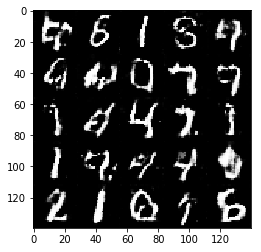

Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 1.3284
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.5582
Epoch 2/2... Discriminator Loss: 1.7118... Generator Loss: 0.3956
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 1.0000
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 1.1500
Epoch 2/2... Discriminator Loss: 2.3466... Generator Loss: 0.1929
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 0.5448
Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 0.6526
Epoch 2/2... Discriminator Loss: 1.1348... Generator Loss: 0.9478


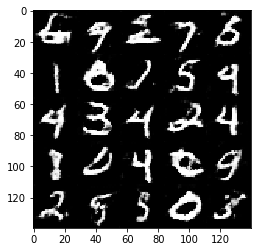

Epoch 2/2... Discriminator Loss: 0.8282... Generator Loss: 1.2104
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.5435
Epoch 2/2... Discriminator Loss: 1.3958... Generator Loss: 2.2010
Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 1.2273
Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.5749
Epoch 2/2... Discriminator Loss: 1.2599... Generator Loss: 1.6197
Epoch 2/2... Discriminator Loss: 2.1293... Generator Loss: 0.2153
Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.5675
Epoch 2/2... Discriminator Loss: 0.8779... Generator Loss: 1.1453
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 1.9138


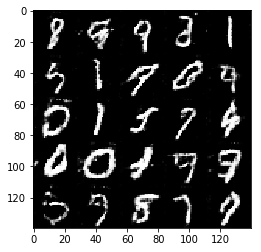

Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 1.5957... Generator Loss: 0.4341
Epoch 2/2... Discriminator Loss: 1.6794... Generator Loss: 2.3254
Epoch 2/2... Discriminator Loss: 1.4654... Generator Loss: 0.5077
Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 1.4357
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.4967
Epoch 2/2... Discriminator Loss: 1.7737... Generator Loss: 0.3280
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 1.8341... Generator Loss: 3.1996
Epoch 2/2... Discriminator Loss: 1.6792... Generator Loss: 0.4074


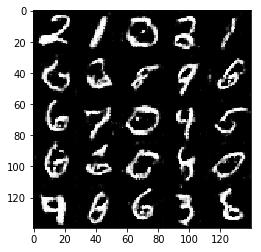

Epoch 2/2... Discriminator Loss: 1.5548... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 1.7394... Generator Loss: 0.3558
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 0.9397
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 0.5792
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 1.2753
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 0.8857
Epoch 2/2... Discriminator Loss: 2.1505... Generator Loss: 0.2080
Epoch 2/2... Discriminator Loss: 1.0965... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 1.8076... Generator Loss: 0.3062
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.5332


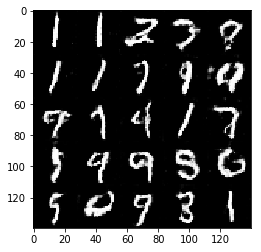

Epoch 2/2... Discriminator Loss: 1.5266... Generator Loss: 0.4322
Epoch 2/2... Discriminator Loss: 0.8929... Generator Loss: 0.9910
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.5447
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 2.1821
Epoch 2/2... Discriminator Loss: 1.9916... Generator Loss: 2.8424
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.4898
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 1.3586
Epoch 2/2... Discriminator Loss: 1.7254... Generator Loss: 0.5342
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 1.5315
Epoch 2/2... Discriminator Loss: 0.8759... Generator Loss: 1.1847


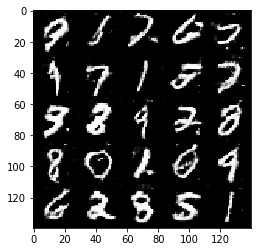

Epoch 2/2... Discriminator Loss: 1.0137... Generator Loss: 1.9538
Epoch 2/2... Discriminator Loss: 1.2057... Generator Loss: 0.6276
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 0.9996
Epoch 2/2... Discriminator Loss: 1.9401... Generator Loss: 0.3374
Epoch 2/2... Discriminator Loss: 1.5142... Generator Loss: 0.4626
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.7671


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 6.3173
Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 4.5935
Epoch 1/1... Discriminator Loss: 0.4224... Generator Loss: 6.6503
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.6150
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 2.5200
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 1.8461
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.8533


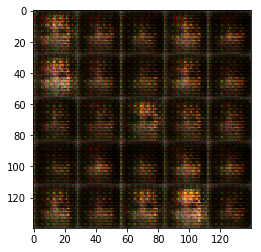

Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 1.4825
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 2.4742
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.7257
Epoch 1/1... Discriminator Loss: 0.7048... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 2.5842
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.3829
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.8607


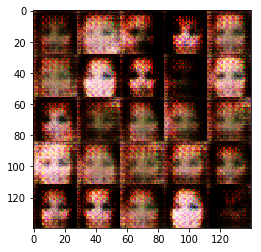

Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 2.0906
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 2.2241
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 2.6077
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 3.2316
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.5473
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 2.1446


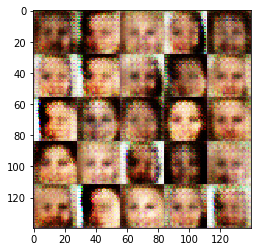

Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.6127
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 1.5896
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.4967


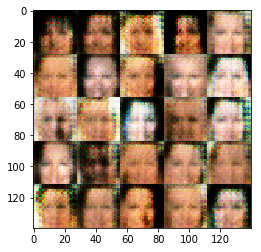

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 1.4793
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.3437
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.8732


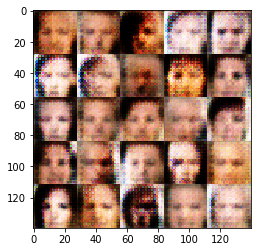

Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 1.5053
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.6723


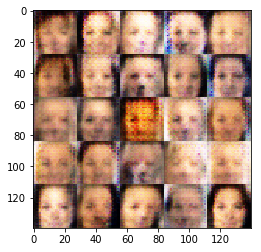

Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 1.6314... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.1369
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.8401
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.8010


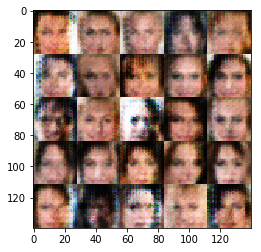

Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.1851
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.0445


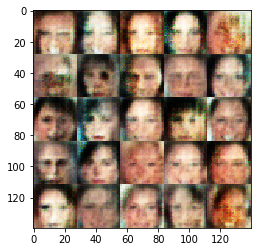

Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 2.0807
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.8410


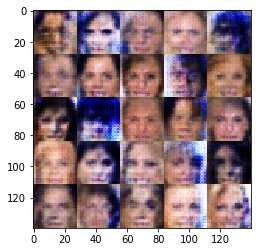

Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.3075


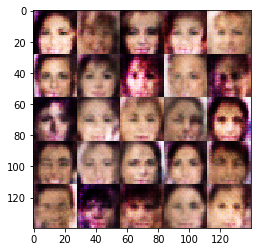

Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.2246
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 1.1678


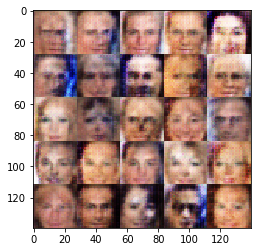

Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.7510
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.0426


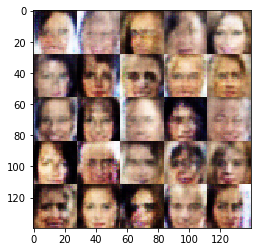

Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 1.1210
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 1.0939


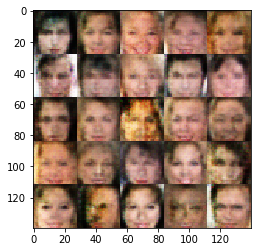

Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.0964


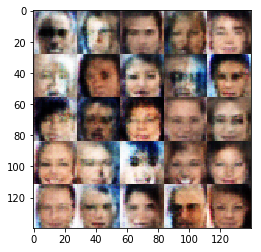

Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.9490


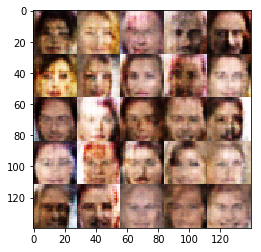

Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.0800


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.